# Final Highway Network Experiment Analysis
This one uses the increase_ego_reward_importance setting and estimates the objective weights of the uncontrolled vehicles

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import os
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from src.utils import calc_hypervolume

## Loading the data

In [2]:
def load_merged_dataframe(literal_str):
    file_list = glob.glob(literal_str)
    df = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
    return df

In [3]:
#load the data
#first two configs
summary_files = os.path.join("data/moma_circle_final/", "moma_circle_final*summary.csv")
detail_files = os.path.join("data/moma_circle_final/", "moma_circle_final*detail.csv")
loss_files = os.path.join("data/moma_circle_final/", "moma_circle_final*loss.csv")

df_summary = load_merged_dataframe(summary_files)
df_detail = load_merged_dataframe(detail_files)
df_loss = load_merged_dataframe(loss_files)

KeyboardInterrupt: 

In [ ]:
print("Summary:")
df_summary.info()
print("Detail:")
df_detail.info()
print("Loss")
df_loss.info()

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45600 entries, 0 to 45599
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         45600 non-null  int64  
 1   repetition_number                  45600 non-null  int64  
 2   weight_index                       45600 non-null  int64  
 3   weight_tuple                       45600 non-null  object 
 4   num_iterations                     45600 non-null  int64  
 5   vehicle_id                         45600 non-null  int64  
 6   normalised_speed_reward            45600 non-null  float64
 7   normalised_energy_reward           45600 non-null  float64
 8   raw_speed_reward                   45600 non-null  float64
 9   raw_energy_reward                  45600 non-null  float64
 10  env_config_id                      45600 non-null  int64  
 11  experiment_id                      45600 non-

## Data Preprocessing

In [ ]:
def add_cv_ratio(df):
    df["controlled_vehicle_ratio"] = 0.0
    df.loc[df["env_config_id"] == 0, "controlled_vehicle_ratio"] = 2/20
    df.loc[df["env_config_id"] == 1, "controlled_vehicle_ratio"] = 8/20
    df.loc[df["env_config_id"] == 2, "controlled_vehicle_ratio"] = 14/20
    return df

def shorten_reward_structure_names(df):
    #exclude the suffix "reward" for entries the reward structure column
    df["reward_structure"] = df["reward_structure"].apply(lambda row: row.split("_")[0])

    #remap the use_multi_dqn column to explicitly state the employed reward structure
    df["use_multi_dqn"] = df["use_multi_dqn"].astype(str)
    df.loc[df["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
    df.loc[df["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"
    return df

def add_config_names(df):
    df["alg_config"] = df.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["alg_config"].value_counts())

    df["exp_config"] = df.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["exp_config"].value_counts())

    return df

def extend_dataframe(df):
    df = add_cv_ratio(df)
    df = shorten_reward_structure_names(df)
    df = add_config_names(df)
    return df

In [ ]:
df_summary = extend_dataframe(df_summary)
df_detail = extend_dataframe(df_detail)
df_loss = extend_dataframe(df_loss)
df_summary["controlled_vehicle_ratio"].value_counts()
df_summary["speed_weight"] = df_summary["weight_index"] / df_summary["weight_index"].max()

alg_config
NS_basic_RS_ego         15200
NS_basic_RS_mean        15200
NS_separated_RS_mean    15200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_mean        8000
CVR_0.7_NS_basic_RS_ego         8000
CVR_0.7_NS_separated_RS_mean    8000
CVR_0.4_NS_basic_RS_ego         5600
CVR_0.4_NS_basic_RS_mean        5600
CVR_0.4_NS_separated_RS_mean    5600
CVR_0.1_NS_basic_RS_ego         1600
CVR_0.1_NS_basic_RS_mean        1600
CVR_0.1_NS_separated_RS_mean    1600
Name: count, dtype: int64
alg_config
NS_basic_RS_mean        2646476
NS_separated_RS_mean    2564968
NS_basic_RS_ego         2103388
Name: count, dtype: int64
exp_config
CVR_0.1_NS_basic_RS_mean        990360
CVR_0.1_NS_separated_RS_mean    958244
CVR_0.4_NS_separated_RS_mean    901992
CVR_0.1_NS_basic_RS_ego         898016
CVR_0.4_NS_basic_RS_ego         845096
CVR_0.7_NS_basic_RS_mean        841092
CVR_0.4_NS_basic_RS_mean        815024
CVR_0.7_NS_separated_RS_mean    704732
CVR_0.7_NS_basic_RS_ego         360276
Name: co

In [ ]:
df_detail["speed_weight"] = df_detail["weight_index"] / df_detail["weight_index"].max()

In [ ]:
#exclude the suffix "reward" for entries the reward structure column
df_summary["reward_structure"] = df_summary["reward_structure"].apply(lambda row: row.split("_")[0])

#remap the use_multi_dqn column to explicitly state the employed reward structure
df_summary["use_multi_dqn"] = df_summary["use_multi_dqn"].astype(str)
df_summary.loc[df_summary["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
df_summary.loc[df_summary["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"

In [ ]:
print(df_summary["reward_structure"].value_counts())
print(df_summary["use_multi_dqn"].value_counts())

reward_structure
mean    30400
ego     15200
Name: count, dtype: int64
use_multi_dqn
basic        30400
separated    15200
Name: count, dtype: int64


In [ ]:
# add experiment configuration name
df_summary["alg_config"] = df_summary.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["alg_config"].value_counts())

df_summary["exp_config"] = df_summary.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["exp_config"].value_counts())

alg_config
NS_basic_RS_ego         15200
NS_basic_RS_mean        15200
NS_separated_RS_mean    15200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_mean        8000
CVR_0.7_NS_basic_RS_ego         8000
CVR_0.7_NS_separated_RS_mean    8000
CVR_0.4_NS_basic_RS_ego         5600
CVR_0.4_NS_basic_RS_mean        5600
CVR_0.4_NS_separated_RS_mean    5600
CVR_0.1_NS_basic_RS_ego         1600
CVR_0.1_NS_basic_RS_mean        1600
CVR_0.1_NS_separated_RS_mean    1600
Name: count, dtype: int64


## Data Analysis

### Pareto front estimation

Text(0.5, 0, 'Normalised Speed Reward')

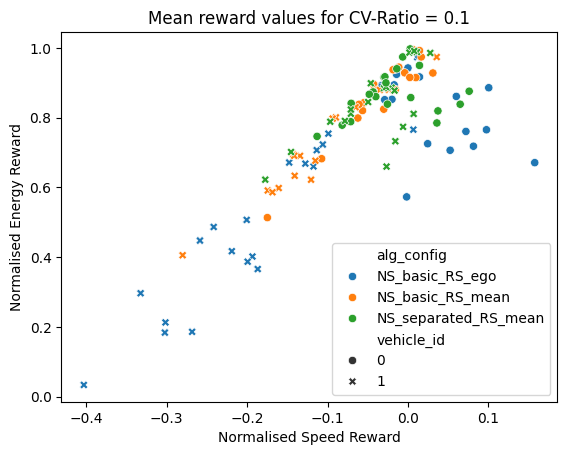

In [ ]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward", "normalised_speed_reward"]].mean()
ax = sns.scatterplot(grouped_df, x="normalised_speed_reward", y="normalised_energy_reward", style="vehicle_id",hue="alg_config")
ax.set_title("Mean reward values for CV-Ratio = 0.1")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Normalised Speed Reward")

This plot shows how for this specific cv ratio, the baseline algorithm does best, supposedly because they only care about their own reward. For the mean algo's on the other hand, the vehicle rewards have a lower variance because they care about the rewards of other vehicles as well. If that first impression holds, we will see when looking at the boxplots.

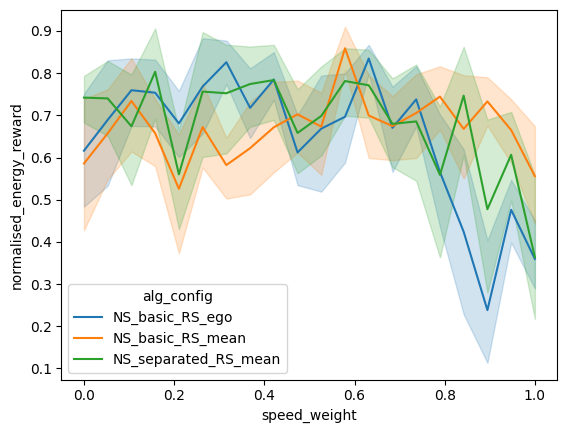

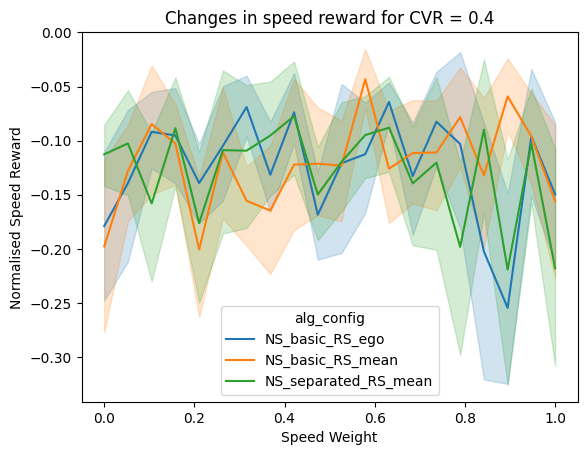

In [ ]:
#TODO: two lineplots: one for the energy reward, one for the speeds reward chosing how they change when increasing the preference for speed, i.e. weight index on the x-axis
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.4].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.4")
plt.show()

#0.4 ratio

The ego one does way better than the mean ones in producing very different policies when changing the preferences. This can be attributed to them not caring about other vehicles. The mean ones on the other hand have a much more subtle change in rewards when changing the weight index. This might be caused by several factors. First off, they care about the other vehicle's returns, so they might use different actions because it would increase the mean utility for the close vehicles. Interestingly, when increasing the ratio of vehicles that are controlled to 0.7, the ego algorithm behaves the same, which might be because the controlled vehicles are actually impeding with each other, everyone trying to get out on top (indicated by the high variation is speeds), while the variance for the mean algorithms, the mean separated one in particular, are much lower. This indicates that is has an easier time accurately assessing the social q-values for the close vehicles.

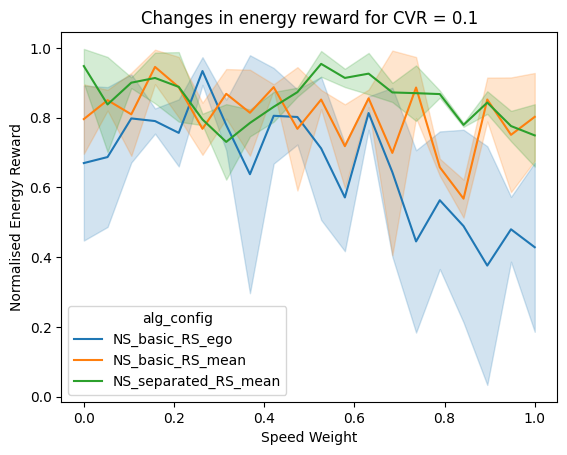

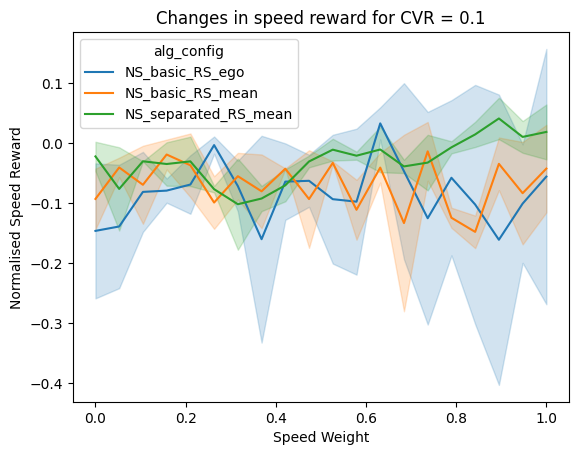

In [ ]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in energy reward for CVR = 0.1")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.1")
plt.show()

#0.4 ratio

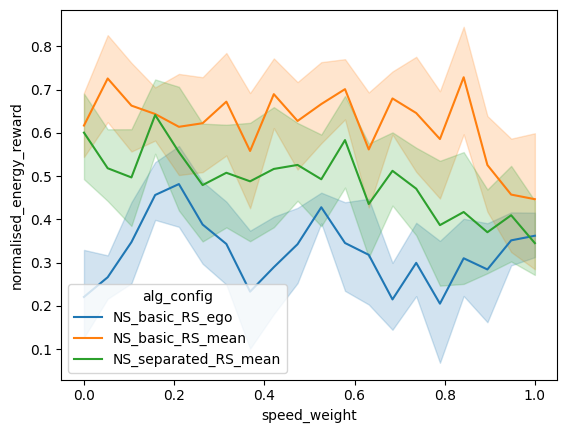

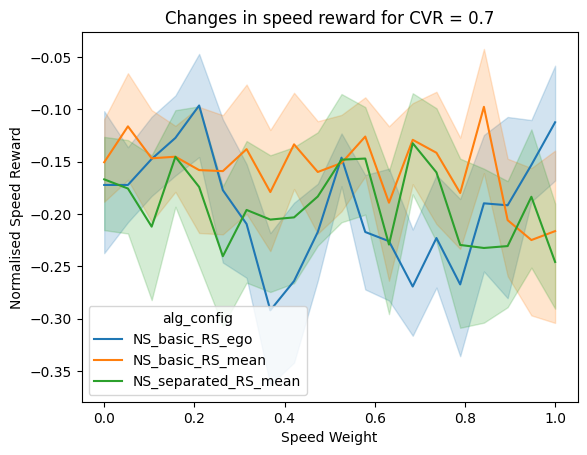

In [ ]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.7].groupby(["alg_config","speed_weight", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="speed_weight", y="normalised_energy_reward", hue="alg_config")
plt.show()
ax = sns.lineplot(grouped_df, x="speed_weight", y="normalised_speed_reward", hue="alg_config")
ax.set_ylabel("Normalised Speed Reward")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed reward for CVR = 0.7")
plt.show()

#0.7 ratio

### Speeds instead of speed rewards

In [ ]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7314832 entries, 0 to 7314831
Data columns (total 27 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Unnamed: 0                         int64  
 1   repetition_number                  int64  
 2   weight_index                       int64  
 3   weight_tuple                       object 
 4   iteration                          int64  
 5   vehicle_id                         int64  
 6   controlled_flag                    int64  
 7   action                             float64
 8   target_speed                       float64
 9   curr_speed                         float64
 10  acc                                float64
 11  lane                               int64  
 12  curr_speed_reward                  float64
 13  curr_energy_reward                 float64
 14  env_config_id                      int64  
 15  experiment_id                      int64  
 16  replay_buffer_size

In [ ]:
grouped_df = df_detail[df_detail["controlled_flag"] == 1].groupby(["controlled_vehicle_ratio", "alg_config", "speed_weight", "vehicle_id"])["curr_speed"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,controlled_vehicle_ratio,alg_config,speed_weight,vehicle_id,curr_speed
0,0.1,NS_basic_RS_ego,0.000000,0,6.019913
1,0.1,NS_basic_RS_ego,0.000000,7,6.009649
2,0.1,NS_basic_RS_ego,0.052632,0,5.981628
3,0.1,NS_basic_RS_ego,0.052632,7,5.740698
4,0.1,NS_basic_RS_ego,0.105263,0,6.277974
...,...,...,...,...,...
1135,0.7,NS_separated_RS_mean,1.000000,9,6.158179
1136,0.7,NS_separated_RS_mean,1.000000,10,6.290349
1137,0.7,NS_separated_RS_mean,1.000000,11,6.681629
1138,0.7,NS_separated_RS_mean,1.000000,12,6.665667


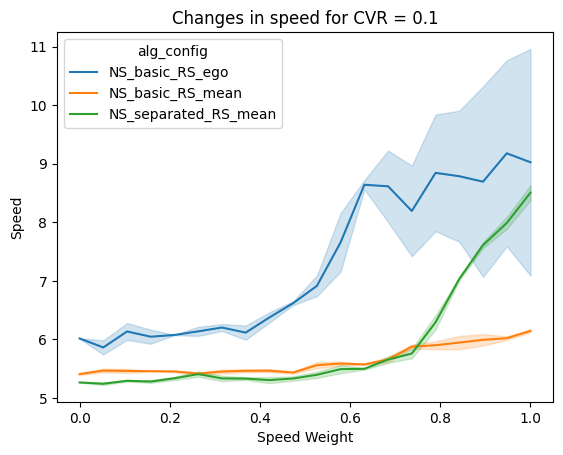

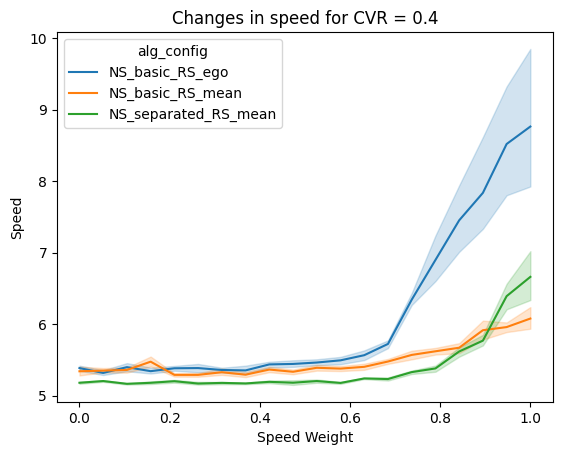

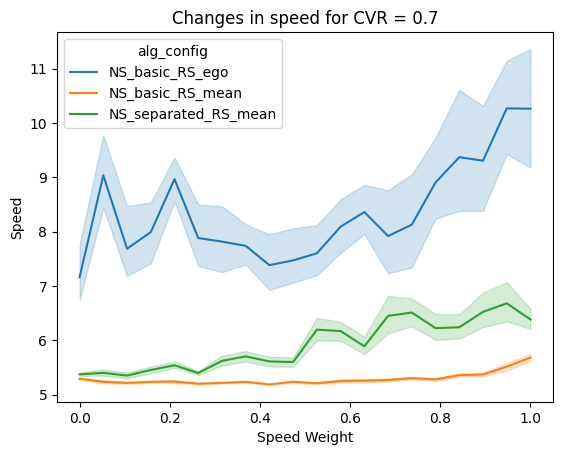

In [ ]:
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.1]
ax = sns.lineplot(data, x="speed_weight", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed for CVR = 0.1")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax = sns.lineplot(data, x="speed_weight", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed for CVR = 0.4")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax = sns.lineplot(data, x="speed_weight", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Speed Weight")
ax.set_title("Changes in speed for CVR = 0.7")
plt.show()

### Speed over time for uncontrolled vehicles

In [ ]:
grouped_df = df_detail[df_detail["controlled_flag"] == 0].groupby(["controlled_vehicle_ratio", "alg_config", "speed_weight", "vehicle_id", "iteration"])["curr_speed"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,controlled_vehicle_ratio,alg_config,speed_weight,vehicle_id,iteration,curr_speed
0,0.1,NS_basic_RS_ego,0.0,1,0,11.004599
1,0.1,NS_basic_RS_ego,0.0,1,1,10.070507
2,0.1,NS_basic_RS_ego,0.0,1,2,9.594021
3,0.1,NS_basic_RS_ego,0.0,1,3,9.532870
4,0.1,NS_basic_RS_ego,0.0,1,4,9.500209
...,...,...,...,...,...,...
137615,0.7,NS_separated_RS_mean,1.0,7,95,4.999999
137616,0.7,NS_separated_RS_mean,1.0,7,96,5.000000
137617,0.7,NS_separated_RS_mean,1.0,7,97,5.000000
137618,0.7,NS_separated_RS_mean,1.0,7,98,5.000000


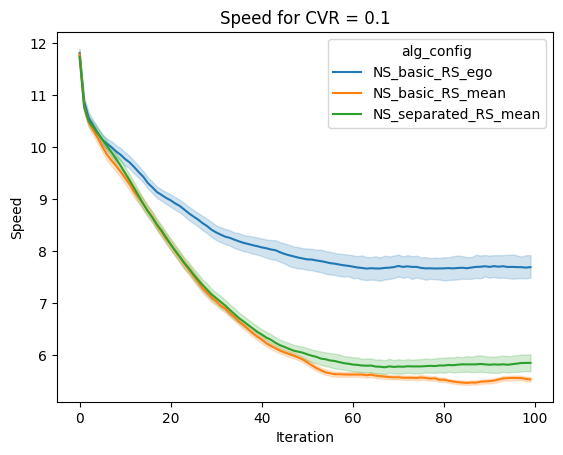

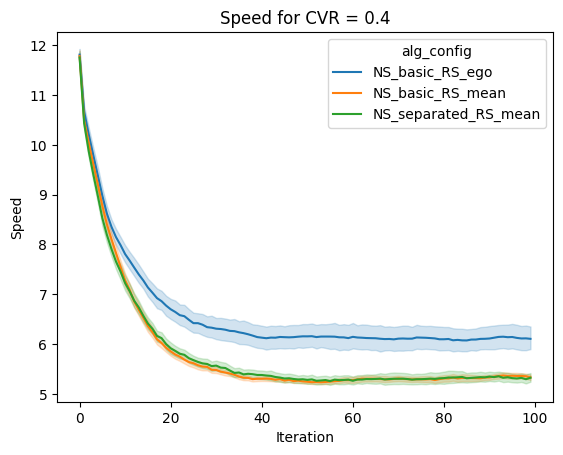

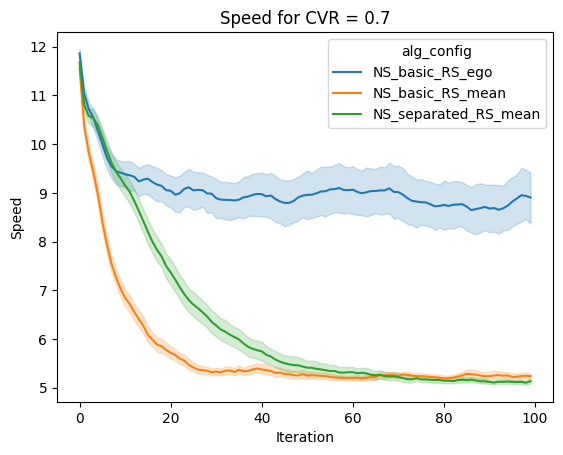

In [ ]:
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.1]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Speed for CVR = 0.1")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Speed for CVR = 0.4")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Speed for CVR = 0.7")
plt.show()

### Speed over time for controlled vehicles

In [ ]:
grouped_df = df_detail[df_detail["controlled_flag"] == 1].groupby(["controlled_vehicle_ratio", "alg_config", "speed_weight", "vehicle_id", "iteration"])["curr_speed"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,controlled_vehicle_ratio,alg_config,speed_weight,vehicle_id,iteration,curr_speed
0,0.1,NS_basic_RS_ego,0.0,0,0,12.392941
1,0.1,NS_basic_RS_ego,0.0,0,1,9.656595
2,0.1,NS_basic_RS_ego,0.0,0,2,7.801655
3,0.1,NS_basic_RS_ego,0.0,0,3,6.650196
4,0.1,NS_basic_RS_ego,0.0,0,4,5.972925
...,...,...,...,...,...,...
113045,0.7,NS_separated_RS_mean,1.0,13,95,5.000000
113046,0.7,NS_separated_RS_mean,1.0,13,96,5.000000
113047,0.7,NS_separated_RS_mean,1.0,13,97,5.000000
113048,0.7,NS_separated_RS_mean,1.0,13,98,5.000000


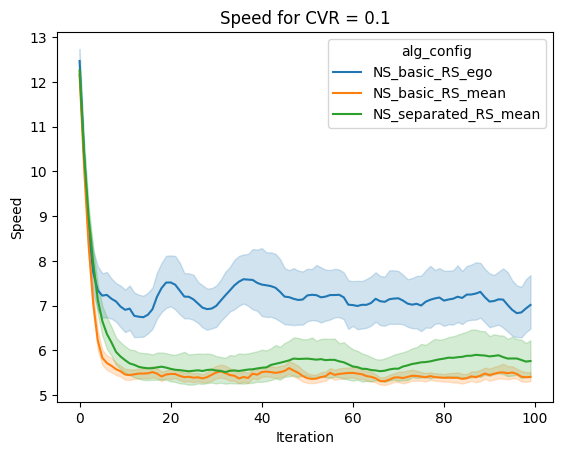

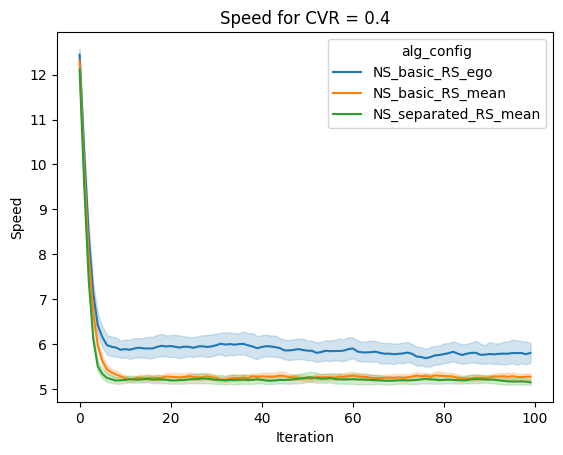

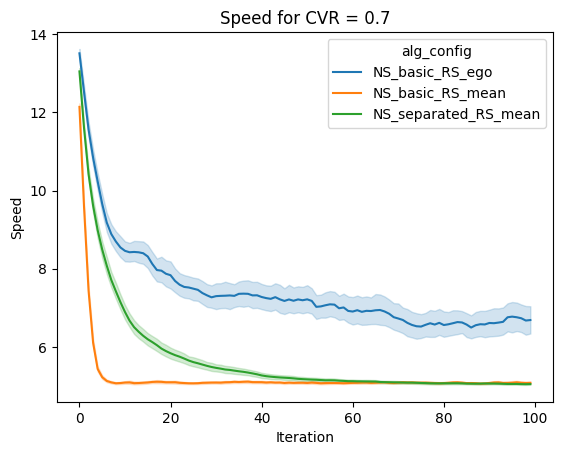

In [ ]:
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.1]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Speed for CVR = 0.1")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.4]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Speed for CVR = 0.4")
plt.show()
data = grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7]
ax = sns.lineplot(data, x="iteration", y="curr_speed", hue="alg_config")
ax.set_ylabel("Speed")
ax.set_xlabel("Iteration")
ax.set_title("Speed for CVR = 0.7")
plt.show()

### Number of iterations before crash

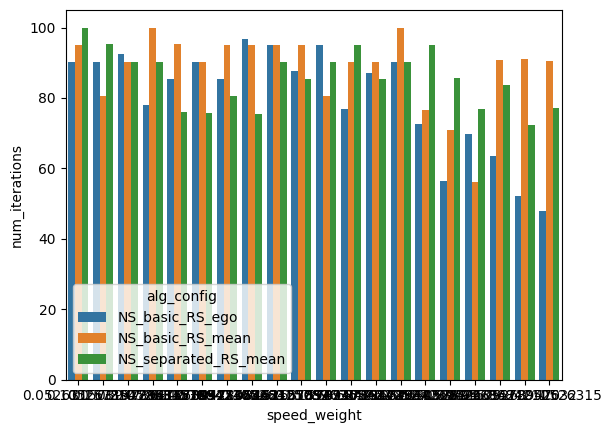

In [ ]:
#TODO: num iterations before a crash
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","speed_weight", "vehicle_id"])[["num_iterations"]].mean()
sns.barplot(grouped_df, x="speed_weight", y="num_iterations", hue="alg_config")
plt.show()

All approximately the same

### Plots of hypervolume distribution among vehicles of the same experiment

In [ ]:
#compute hypervolume for all vehicles
hv_data = []
grouped_data = df_summary.groupby(["controlled_vehicle_ratio","alg_config","vehicle_id"])
for (cvr, alg_config, vehicle_id), group in grouped_data:
    group_data = group[["normalised_speed_reward","normalised_energy_reward"]].to_numpy()
    hv = calc_hypervolume(reward_vector=group_data)
    hv_data.append({"controlled_vehicle_ratio": cvr, "alg_config":alg_config, "vehicle_id": vehicle_id, "hypervolume":hv})

hv_df = pd.DataFrame(hv_data)
display(hv_df)
#TODO: construct scatterplot and then boxplot of the hypervolumes for the vehicles grouped by ratio of controlled vehicles and by reward/network structure
#compute hypervolume




Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



,controlled_vehicle_ratio,alg_config,vehicle_id,hypervolume
0,0.1,NS_basic_RS_ego,0,0.328615
1,0.1,NS_basic_RS_ego,1,0.382418
2,0.1,NS_basic_RS_mean,0,0.205235
3,0.1,NS_basic_RS_mean,1,0.313597
4,0.1,NS_separated_RS_mean,0,0.297385
5,0.1,NS_separated_RS_mean,1,0.337947
6,0.4,NS_basic_RS_ego,0,0.333862
7,0.4,NS_basic_RS_ego,1,0.455232
8,0.4,NS_basic_RS_ego,2,0.647839
9,0.4,NS_basic_RS_ego,3,0.577914


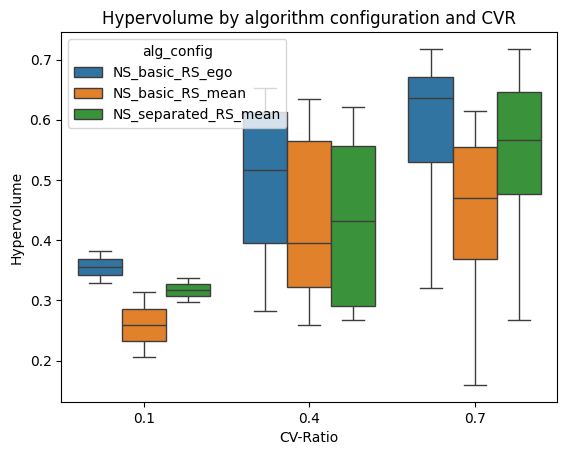

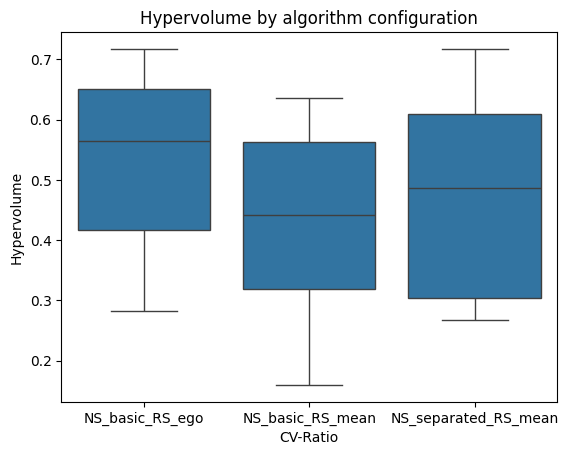

In [ ]:
ax = sns.boxplot(hv_df, x="controlled_vehicle_ratio", y="hypervolume", hue="alg_config")
ax.set_ylabel("Hypervolume")
ax.set_xlabel("CV-Ratio")
ax.set_title("Hypervolume by algorithm configuration and CVR")
plt.show()

#avg hypervolume
ax = sns.boxplot(hv_df, x="alg_config", y="hypervolume")
ax.set_ylabel("Hypervolume")
ax.set_xlabel("CV-Ratio")
ax.set_title("Hypervolume by algorithm configuration")
plt.show()
#TODO: hypothesis: the hypervolume is dependent on the vehicle id, 
# because of they way they are spawned (one vehicle is always first, 
# has an easier time optimising their reward as they don't have as many vehicles to overtake): 
# color the dots in the scatterplot by the vehicle_id to see if there is. 
# If that is to messy to see something, try using a barplot/lineplot 
# with the vehicle ID on the x axis and the hypervolume on the y axis

<Axes: xlabel='vehicle_id', ylabel='hypervolume'>

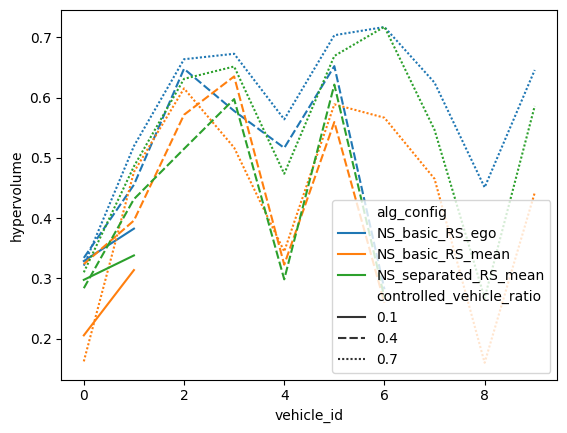

In [ ]:
sns.lineplot(hv_df, x="vehicle_id", y="hypervolume", hue="alg_config", style="controlled_vehicle_ratio")

### Loss analysis

In [ ]:
df_loss

,Unnamed: 0,episode,loss,hypervolume,avg_num_iterations_training,std_num_iterations_training,env_config_id,experiment_id,replay_buffer_size,batch_size,reward_structure,use_multi_dqn,observation_space_name,increase_ego_reward_importance,estimate_uncontrolled_obj_weights,controlled_vehicle_ratio,alg_config,exp_config
0,0,0.0,0.242991,0.0,49.07,47.231302,2,2,10000,100,mean,basic,OccupancyGrid,True,True,0.7,NS_basic_RS_mean,CVR_0.7_NS_basic_RS_mean
1,1,1.0,0.275864,NaN,NaN,NaN,2,2,10000,100,mean,basic,OccupancyGrid,True,True,0.7,NS_basic_RS_mean,CVR_0.7_NS_basic_RS_mean
2,2,2.0,0.260778,NaN,NaN,NaN,2,2,10000,100,mean,basic,OccupancyGrid,True,True,0.7,NS_basic_RS_mean,CVR_0.7_NS_basic_RS_mean
3,3,3.0,0.262704,NaN,NaN,NaN,2,2,10000,100,mean,basic,OccupancyGrid,True,True,0.7,NS_basic_RS_mean,CVR_0.7_NS_basic_RS_mean
4,4,4.0,0.239727,NaN,NaN,NaN,2,2,10000,100,mean,basic,OccupancyGrid,True,True,0.7,NS_basic_RS_mean,CVR_0.7_NS_basic_RS_mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,1995,1995.0,0.225399,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean
35996,1996,1996.0,0.153229,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean
35997,1997,1997.0,0.145466,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean
35998,1998,1998.0,0.158423,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean


In [ ]:
#TODO: look at how the loss (and maybe the hypervolume) changes while training for all the algorithm configurations
grouped_df = df_loss.groupby(["alg_config", "controlled_vehicle_ratio", "episode"])["loss"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_vehicle_ratio,episode,loss
0,NS_basic_RS_ego,0.1,0.0,0.255805
1,NS_basic_RS_ego,0.1,1.0,0.306281
2,NS_basic_RS_ego,0.1,2.0,0.269857
3,NS_basic_RS_ego,0.1,3.0,0.257356
4,NS_basic_RS_ego,0.1,4.0,0.356510
...,...,...,...,...
17987,NS_separated_RS_mean,0.7,1995.0,0.481536
17988,NS_separated_RS_mean,0.7,1996.0,0.641353
17989,NS_separated_RS_mean,0.7,1997.0,0.692759
17990,NS_separated_RS_mean,0.7,1998.0,0.679892


<Axes: xlabel='episode', ylabel='loss'>

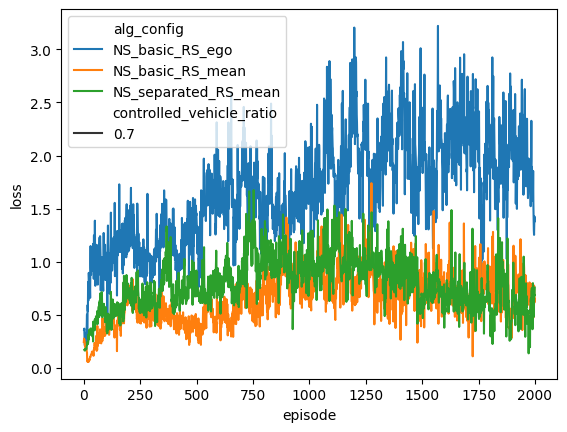

In [ ]:
sns.lineplot(grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7], x="episode", y="loss", hue="alg_config", style="controlled_vehicle_ratio")

### Detail df analysis

In [ ]:
df_detail["speed_diff"] = np.abs(df_detail["target_speed"] - df_detail["curr_speed"])
df_detail["abs_acc"] = np.abs(df_detail["acc"])
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7314832 entries, 0 to 7314831
Data columns (total 29 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Unnamed: 0                         int64  
 1   repetition_number                  int64  
 2   weight_index                       int64  
 3   weight_tuple                       object 
 4   iteration                          int64  
 5   vehicle_id                         int64  
 6   controlled_flag                    int64  
 7   action                             float64
 8   target_speed                       float64
 9   curr_speed                         float64
 10  acc                                float64
 11  lane                               int64  
 12  curr_speed_reward                  float64
 13  curr_energy_reward                 float64
 14  env_config_id                      int64  
 15  experiment_id                      int64  
 16  replay_buffer_size

In [ ]:
grouped_df = df_detail.groupby(["alg_config","controlled_flag", "controlled_vehicle_ratio", "repetition_number","iteration"])["abs_acc"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_flag,controlled_vehicle_ratio,repetition_number,iteration,abs_acc
0,NS_basic_RS_ego,0,0.1,0,0,1.632748e+00
1,NS_basic_RS_ego,0,0.1,0,1,7.802934e-01
2,NS_basic_RS_ego,0,0.1,0,2,6.835504e-01
3,NS_basic_RS_ego,0,0.1,0,3,6.327690e-01
4,NS_basic_RS_ego,0,0.1,0,4,5.895213e-01
...,...,...,...,...,...,...
35995,NS_separated_RS_mean,1,0.7,19,95,6.027771e-15
35996,NS_separated_RS_mean,1,0.7,19,96,6.027771e-15
35997,NS_separated_RS_mean,1,0.7,19,97,6.027771e-15
35998,NS_separated_RS_mean,1,0.7,19,98,6.027771e-15


### uncontrolled vehicles

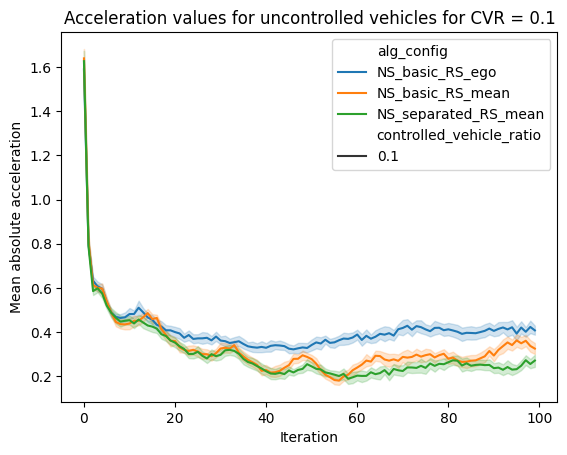

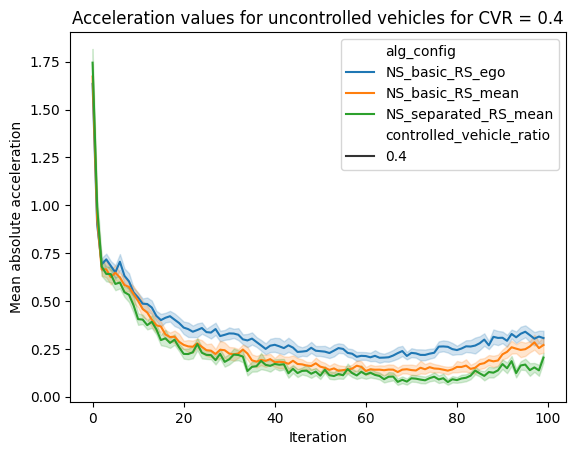

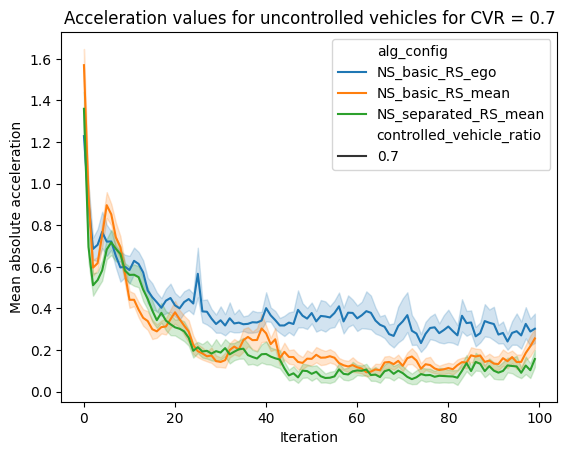

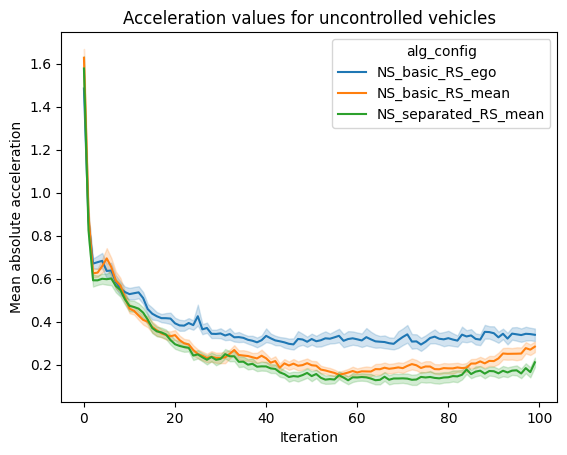

In [ ]:
data = grouped_df[grouped_df["controlled_flag"] == 0]
ax = sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.1], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles for CVR = 0.1")
plt.show()
ax = sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.4], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles for CVR = 0.4")
plt.show()
ax = sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.7], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles for CVR = 0.7")
plt.show()

#averaged over all cvr's
ax = sns.lineplot(data, x="iteration", y="abs_acc", hue="alg_config")
ax.set_ylabel("Mean absolute acceleration")
ax.set_xlabel("Iteration")
ax.set_title("Acceleration values for uncontrolled vehicles")
plt.show()